In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

from my_imports import acf_plot
from my_imports import sarimax_plot, sarimax_eval
from File_creation import gap_less

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

#code in this notebook inspired by https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#and Kiefer Katovich

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


/Users/mauriekathan/anaconda3/envs/dsi/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (10,12,13,16,17,18,22,24,28,30,32,37,43,49,52,54,58,60,68,70,74,77,79,80,82,84,86,88,90,92,100,101,102,103,104,106,108,119,121,124,125,126,127,133,142,144,146,148,150,152,158,160,162,164,166,168,170,176,179,181,185,187,188,194) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/mauriekathan/anaconda3/envs/dsi/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


## Creating Dissolved Oxygen Dataset

In [2]:
#created aggregated dataframe with which averages the data from all of the sites.
agg_data = gap_less.groupby(gap_less.index).mean()

In [3]:
#creating dissolved only dataframe
do_data = agg_data[['dissolved_oxygen']]

## Normalizing the Data

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_nm = scaler.fit_transform(do_data)

In [5]:
data_nm.shape

(233, 1)

## Train Test

In [6]:
#identifying shape of training set
data_nm.shape[0] * .8

186.4

In [7]:
#Slitting data into training and testing shapes
train = data_nm[0:186]
test = data_nm[186:]

In [8]:
test.shape

(47, 1)

In [9]:
train.shape

(186, 1)

## LSTM

In [10]:
# convert an array of values into a dataset matrix which is need for the LSTM
def create_dataset(dataset, look_back=1):
    #creating lists for each X and Y (X is variable at time t, y is variable at t+lookback)
    dataX, dataY = [], []
    #looping to create the different arrays
    for i in range(len(dataset)-look_back-1):
        #indexing the data for the X
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        #indexing for y
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshaping the data so that it works within a LSTM structure
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, 
               batch_input_shape=(batch_size, trainX.shape[1], trainX.shape[2]), 
               stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0643
Epoch 2/100
 - 0s - loss: 0.0133
Epoch 3/100
 - 0s - loss: 0.0133
Epoch 4/100
 - 0s - loss: 0.0130
Epoch 5/100
 - 0s - loss: 0.0126
Epoch 6/100
 - 0s - loss: 0.0126
Epoch 7/100
 - 0s - loss: 0.0128
Epoch 8/100
 - 0s - loss: 0.0133
Epoch 9/100
 - 0s - loss: 0.0124
Epoch 10/100
 - 0s - loss: 0.0130
Epoch 11/100
 - 0s - loss: 0.0134
Epoch 12/100
 - 0s - loss: 0.0125
Epoch 13/100
 - 0s - loss: 0.0132
Epoch 14/100
 - 0s - loss: 0.0128
Epoch 15/100
 - 0s - loss: 0.0128
Epoch 16/100
 - 0s - loss: 0.0134
Epoch 17/100
 - 0s - loss: 0.0126
Epoch 18/100
 - 0s - loss: 0.0123
Epoch 19/100
 - 0s - loss: 0.0122
Epoch 20/100
 - 0s - loss: 0.0119
Epoch 21/100
 - 0s - loss: 0.0124
Epoch 22/100
 - 0s - loss: 0.0121
Epoch 23/100
 - 0s - loss: 0.0128
Epoch 24/100
 - 0s - loss: 0.0126
Epoch 25/100
 - 0s - loss: 0.0119
Epoch 26/100
 - 0s - loss: 0.0121
Epoch 27/100
 - 0s - loss: 0.0122
Epoch 28/100
 - 1s - loss: 0.0114
Epoch 29/100
 - 1s - loss: 0.0128
Epoch 30/100
 - 1s - lo

In [14]:
# make predictions
trainPredict = model.predict(trainX, batch_size = batch_size)
testPredict = model.predict(testX, batch_size = batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = (mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f MAE' % (trainScore))
testScore = (mean_absolute_error(testY[0], testPredict[:,0]))**(1/2)
print('Test Score: %.2f MAE' % (testScore))

Train Score: 0.99 MAE
Test Score: 1.17 MAE


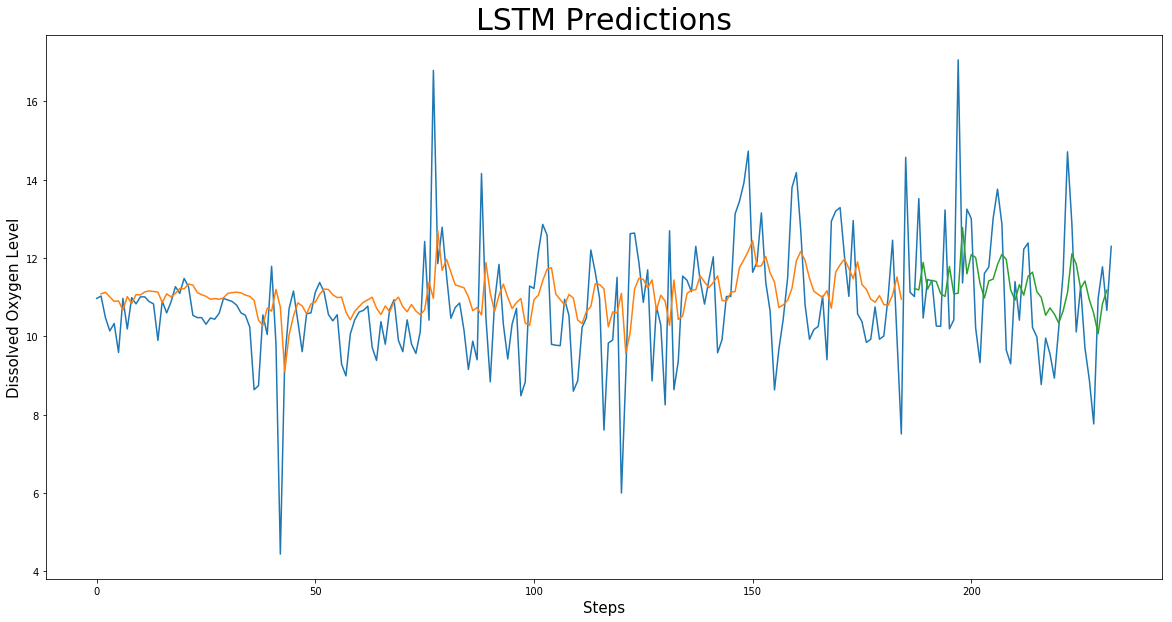

<Figure size 432x288 with 0 Axes>

In [17]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_nm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_nm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data_nm)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(data_nm), label = 'Collected Data')
plt.plot(trainPredictPlot, label = 'Predicted Train')
plt.plot(testPredictPlot, label = 'Predicted Train')
plt.title('LSTM Predictions', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Dissolved Oxygen Level',fontsize=15)
plt.xlabel('Steps',fontsize=15)
plt.show()
plt.savefig('./Images/LSTM_plot.png')